<a href="https://colab.research.google.com/github/Mr-Grag-Universe/NLA_project/blob/main/dac_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
def householder(X, idx):
    n = len(X)

    alpha = -np.sign(X[idx]) * np.linalg.norm(X)
    e = np.zeros(n)
    e[idx] = 1.

    V = X - alpha * e
    V /= np.linalg.norm(V)
    H = np.eye(n) - 2 * np.outer(V, V.T)

    return H

In [ ]:
def bidiagonalization(X):
    col = X.shape[1]
    row = X.shape[0]

    X = X.copy()

    for i in range(col-2):
        hl = np.zeros(len(X[:, i]))
        hl[i:] = X[i:, i]
        hl = householder(hl, i)
        X = hl @ X

        hr = np.zeros(len(X[i, :]))
        hr[i+1:] = X[i, i+1:]
        hr = householder(hr, i+1)
        X = X @ hr

    return X

In [ ]:
def bidiagonalization_v2(X):
    col = X.shape[1]
    row = X.shape[0]

    X = X.copy()

    for i in range(col):
        hl = np.zeros(len(X[:, i]))
        hl[i:] = X[i:, i]
        hl = householder(hl, i)
        X = hl @ X

        if i <= (col-2):
            hr = np.zeros(len(X[i, :]))
            hr[i+1:] = X[i, i+1:]
            hr = householder(hr, i+1)
            X = X @ hr

    return X

In [ ]:
n = 50
m = 50
A = np.random.randn(n, m)

In [ ]:
B = bidiagonalization(A)

In [ ]:
np.linalg.norm(A) - np.linalg.norm(B)

0.0

In [ ]:
B2 = bidiagonalization_v2(A)

In [ ]:
np.linalg.norm(A) - np.linalg.norm(B2)

0.0

In [ ]:
np.linalg.norm(B) - np.linalg.norm(B2)

0.0

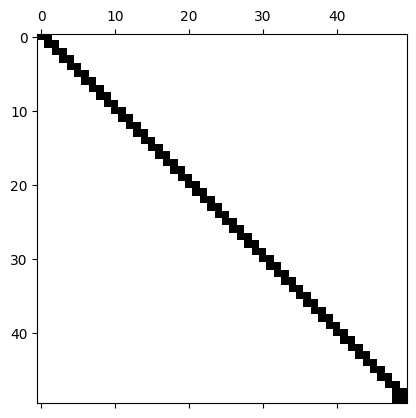

In [ ]:
B_z = B.copy()
B_z[abs(B_z) <= 1e-10] = 0.
plt.spy(B_z)

In [ ]:
T = B.T @ B

In [ ]:
def diagonalization(X, eps=1e-13):
    U = np.eye(X.shape[0])
    X_i = X.copy()

    cnt = 0
    err = np.inf
    while ~np.isclose(err, 0., atol=eps):
        Q, R = jnp.linalg.qr(X_i)

        X_i = R.dot(Q)
        X_i = X_i.at[jnp.abs(X_i) < eps].set(0.)

        U = U @ Q

        cnt += 1
        err = jnp.linalg.norm(X_i-jnp.diag(jnp.diagonal(X_i)), ord="fro")
        # print(f"{cnt}: {err}", flush=True)

    return U, X_i

In [ ]:
def diagonalization_v2(X, eps=1.0e-12):
    U = jnp.eye(X.shape[0])
    X_i = X.copy()

    mu = 0
    err = jnp.inf
    while ~jnp.isclose(err, eps, atol=eps):
        mu_matrix = jnp.identity(X_i.shape[0]) * mu
        Q, R = jnp.linalg.qr(X_i - mu_matrix)

        X_i = R.dot(Q) + mu_matrix
        X_i = X_i.at[jnp.abs(X_i) < eps].set(0.)

        U = U @ Q

        delta = (X_i[-2, -2] - X_i[-1, -1]) / 2.
        if np.isclose(delta, eps, atol=eps):
             mu = X_i[-1, -1] - X_i[-1, -2]
        else:
            mu = X_i[-1, -1] - jnp.sign(delta) * (X_i[-1, -2])**2 / \
             (jnp.abs(delta) + jnp.sqrt(delta**2 + X_i[-1, -2]**2))

        err = jnp.linalg.norm(X_i-jnp.diag(jnp.diagonal(X_i)), ord="fro")
        print(err)

    return U, X_i

In [ ]:
u, x_i = diagonalization(T)

In [ ]:
u2, x_i2 = diagonalization_v2(T)

272.17489718201904
252.0246609041518
235.71022208153323
219.4422395400403
203.77056478658085
192.44234061935686
177.58721361639343
169.39044044533634
157.11029372645416
147.2849807260758
137.9270888099828
129.70844125269335
121.37320522966293
115.41843098818028
108.53504605723786
99.4962642078187
92.58958903805868
86.62516840306823
81.95137315769574
78.1007749901453
73.0649726352982
68.07522115624415
64.56068749708169
61.85715949871335
58.783132239073
55.175909527389244
51.38279852162481
47.70646133299472
44.41919918771049
41.60294721237315
39.11768925821183
36.80695143822014
34.59545215254985
32.44848917503975
30.357407391814426
28.36577762260125
26.571613382556308
25.079382399981963
23.917623885761582
22.97149455200092
22.00647203257537
20.808053469468916
19.327009032938246
17.690020521494187
16.088380730780393
14.669100483665098
13.498036105225584
12.576689329122448
11.872850904606212
11.343822358242212
10.948611506206653
10.652381845866724
10.426958587572402
10.2498606934749
10.103

In [ ]:
jnp.linalg.norm(T - u @ x_i @ u.T, ord="fro")

Array(9.9082724e-09, dtype=float64)

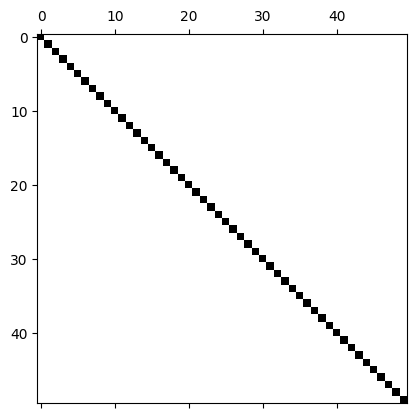

In [ ]:
x_i = x_i.at[abs(x_i) <= 1e-8].set(0.)
plt.spy(x_i)

In [ ]:
jnp.linalg.norm(T - u2 @ x_i2 @ u2.T, ord="fro")

Array(1.39432463e-11, dtype=float64)

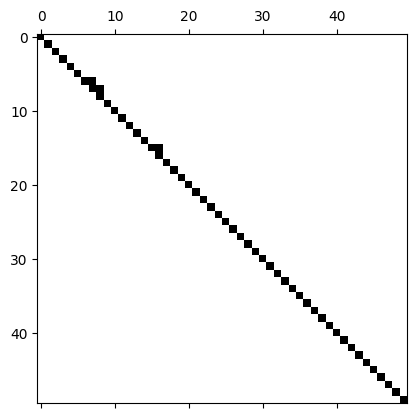

In [ ]:
plt.spy(x_i2)

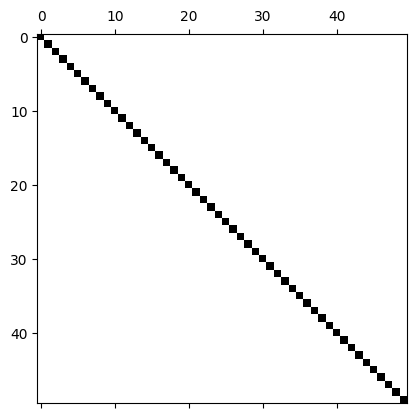

In [ ]:
x_i2_z = x_i2.at[abs(x_i2) <= 1e-11].set(0.)
plt.spy(x_i2_z)

In [ ]:
def eigval_solver():
    pass

In [ ]:
def rec_svd(X):
    m, n = X.shape
    assert m == n, "shape is not square"

    if m <= 25:
        U, L = diagonalization_v2(X)
        return U, L

    m = n // 2

    X1 = X[:m, :m].copy()
    X2 = X[m:, m:].copy()

    assert X[m-1, m] == X[m, m-1], "T is not simmetric"

    b_m = X[m, m-1]

    X1[m-1, m-1] -= b_m
    X2[0, 0] -= b_m

    Q1, L1 = rec_svd(X1)
    Q2, L2 = rec_svd(X2)

    Q = np.zeros_like(X)
    Q[:m, :m] = Q1
    Q[m:, m:] = Q2
    Q = Q.T

    D = np.concatenate((np.diag(L1), np.diag(L2)))

    u = np.zeros_like(D)
    u[:m] = Q1[-1].copy()
    u[m:] = Q2[0].copy()

    L_d, Q_d = eigval_solver(D, b_m, u, m)
    return Q @ Q_d, L_d

In [ ]:
rec_svd(T)

1


NameError: ignored